# 목차
> ### 필요한 라이브러리 Import
> ### 데이터 확인 및 전처리
> ### 학습 및 테스트
> ### cutmix 활용
> ### 학습 및 테스트
> ### data agumentation 비교
> ### Epoch 비교
> ### 회고

## 필요한 라이브러리 Import

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import losses
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers

## 데이터 확인 및 전처리

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


* 1000개의 이미지가 있습니다 한번 확인해보겠습니다.

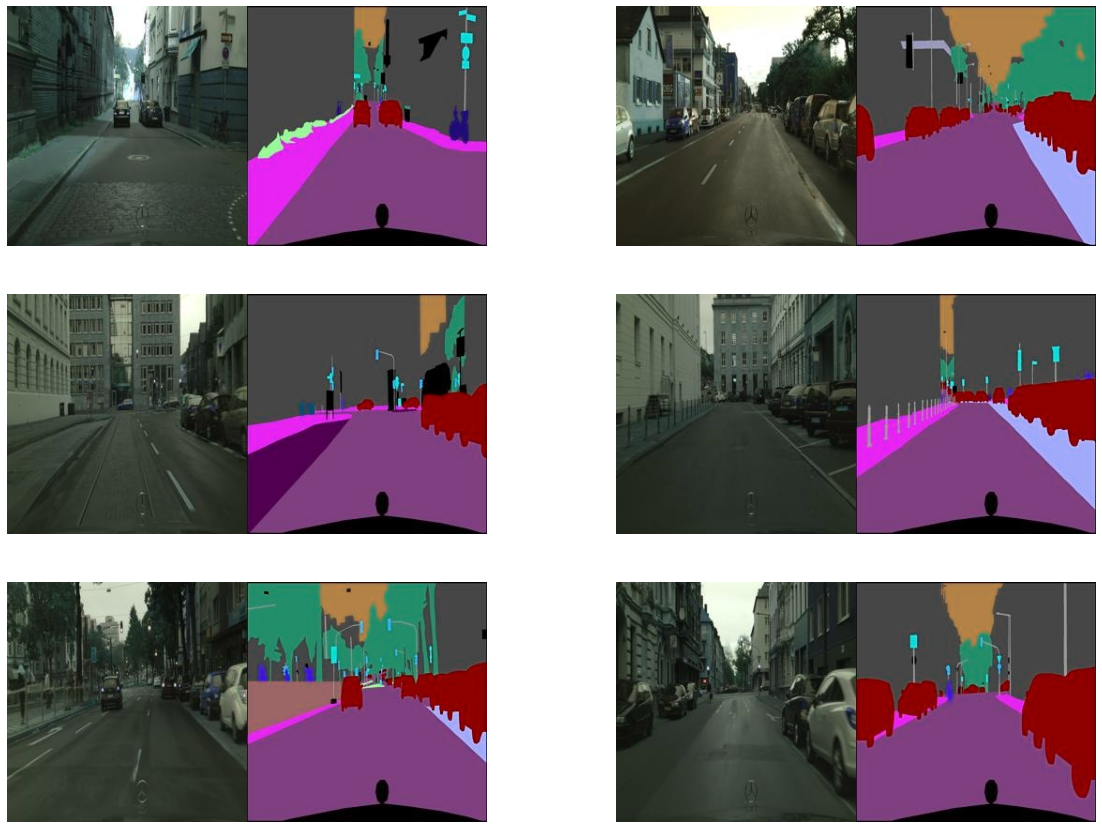

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img); plt.axis('off')

* 예제는 왼쪽이 스케치 오른쪽이 컬러 이미지였는데 반대로 저장되어 있어 뒤에 함수를 수정해야 할것 같습니다.

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* 이미지는 세로 256, 가로 512입니다. 두장으로 나눌거라 (256, 256, 3)이라고 생각하면 될것 같습니다.

(-0.5, 255.5, 255.5, -0.5)

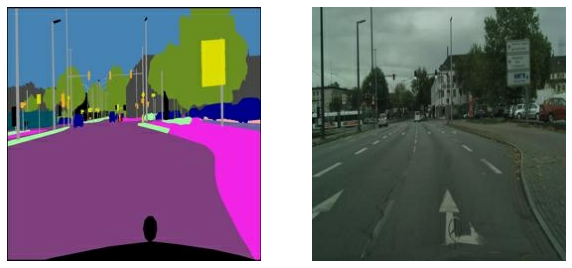

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch)); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(denormalize(colored)); plt.axis('off')

* 두장으로 나누어 보았습니다.

In [6]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


* 학습 이미지의 다양화를 위해 인수를 추가하는 함수를 만들었습니다.

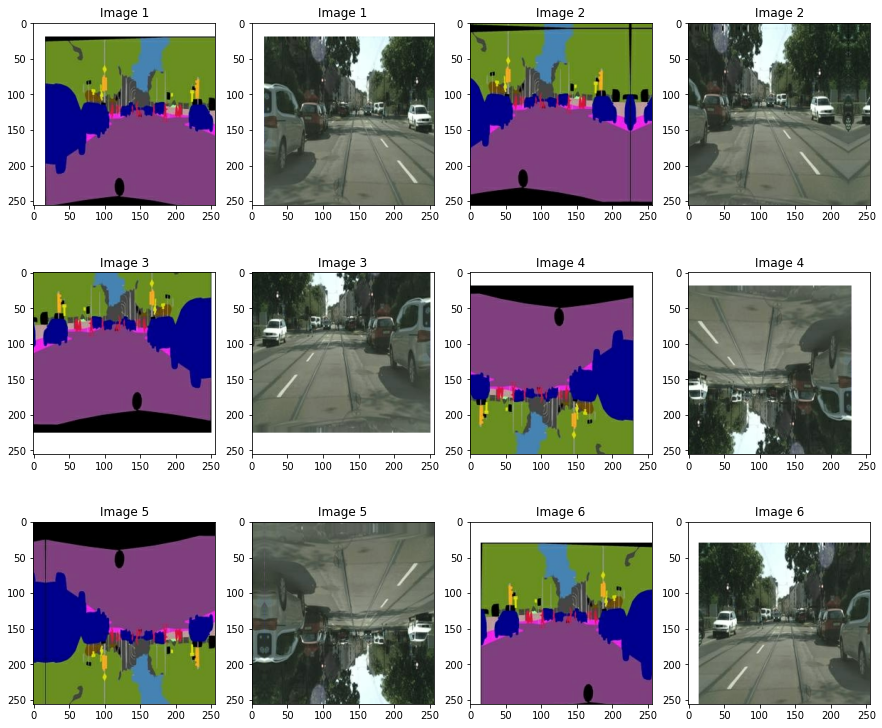

In [42]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

* 회전도 있고 상하좌우 대칭인 이미지, 랜덤으로 잘린 이미지도 확인 됩니다.

(-0.5, 255.5, 255.5, -0.5)

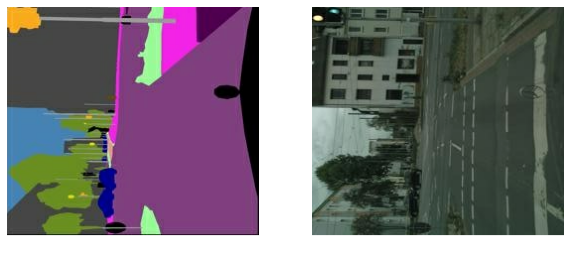

In [8]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8)); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8)); plt.axis('off')

* 인수추가 함수가 잘 작동합니다.

## Generator 구현하기

* 인코더 구현

In [9]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


* 인코더를 위한 인코더 블럭입니다.

In [10]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


* 위의 블럭을 이용해 하나하나 쌓아서 인코더를 만듭니다.

In [11]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

* 디코더 구현

In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


* 위와 마찬가지로 인코더 블럭을 정의한뒤 하나하나 쌓아가면서 디코더를 만듭니다.

In [13]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [14]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


* 마지막으로 둘을 합쳐줍니다.

## Generator 재구성하기
* U-Net 구조를 만들고 실험해보겠습니다.

In [15]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


* 위와 마찬가지로 인코더와 디코더의 블럭을 정의했습니다.

In [16]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


* call 내부에서 인코더와 디코더 블럭을 쌓아 만들었습니다. 

In [17]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

* 파라미터수가 늘어났습니다. 위의 생성자에서 차이점은 디코더의 채널수가 늘어났기 때문에 파라미터가 늘어났습니다.

## Discriminator 구성하기

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


* 출력되는 크기를 확인해보겠습니다.

In [19]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


* layers.ZeroPadding2D() → (130,130,32)<br/>layers.Conv2D(64,4,1,"valid") → (127,127,64)<br/>layers.BatchNormalization() → (127,127,64)<br/>layers.LeakyReLU(0.2) → (127,127,64)

*  Discriminator 만들기

In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


* 위에서 정의한 블록을 쌓았습니다.

In [21]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

* Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞춰야 했습니다.

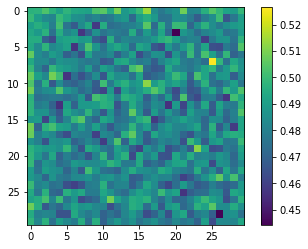

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

* 임의의 이미지를 넣어 (30, 30, 1)이 잘 나오나 확인해보았습니다.

## 학습 및 테스트

In [23]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


* GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈습니다. 그러므로 두가지의 손실함수를 사용하겠습니다.

In [24]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


* optimizer는 논문과 같은 수치로 설정했습니다.

In [25]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


* 학습할 함수를 정의했고 10 에폭 학습해보겠습니다.

In [26]:
EPOCHS = 10

history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}


generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        history['g_loss'].append(g_loss.numpy())
        history['l1_loss'].append(l1_loss.numpy())
        history['d_loss'].append(d_loss.numpy())
        
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9186                     
L1_loss:0.3300                     
Discriminator_loss:1.3216

EPOCH[1] - STEP[20]                     
Generator_loss:0.9358                     
L1_loss:0.2084                     
Discriminator_loss:1.2021

EPOCH[1] - STEP[150]                     
Generator_loss:1.6355                     
L1_loss:0.1673                     
Discriminator_loss:0.9550

EPOCH[1] - STEP[160]                     
Generator_loss:0.9955                     
L1_loss:0.1808                     
Discriminator_loss:1.2532

EPOCH[1] - STEP[170]                     
Generator_loss:1.0778                     
L1_loss:0.2041                     
Discriminator_loss:0.7435

EPOCH[1] - STEP[180]                     
Generator_loss:2.0487                     
L1_loss:0.1923                     
Discriminator_loss:0.8240

EPOCH[1] - STEP[190]                     
Generator_loss:2.1451                     
L1_loss:0.2034               

EPOCH[3] - STEP[190]                     
Generator_loss:0.4542                     
L1_loss:0.1948                     
Discriminator_loss:1.1539

EPOCH[3] - STEP[200]                     
Generator_loss:0.9927                     
L1_loss:0.1842                     
Discriminator_loss:2.0229

EPOCH[3] - STEP[210]                     
Generator_loss:1.6309                     
L1_loss:0.1793                     
Discriminator_loss:0.8523

EPOCH[3] - STEP[220]                     
Generator_loss:0.4625                     
L1_loss:0.2146                     
Discriminator_loss:1.4156

EPOCH[3] - STEP[230]                     
Generator_loss:1.5425                     
L1_loss:0.1804                     
Discriminator_loss:0.7307

EPOCH[3] - STEP[240]                     
Generator_loss:1.2934                     
L1_loss:0.1746                     
Discriminator_loss:1.9305

EPOCH[3] - STEP[250]                     
Generator_loss:1.0785                     
L1_loss:0.1793             

EPOCH[5] - STEP[250]                     
Generator_loss:0.5121                     
L1_loss:0.1844                     
Discriminator_loss:1.2913

EPOCH[6] - STEP[10]                     
Generator_loss:2.7822                     
L1_loss:0.1811                     
Discriminator_loss:0.3308

EPOCH[6] - STEP[20]                     
Generator_loss:0.9316                     
L1_loss:0.1613                     
Discriminator_loss:0.7860

EPOCH[6] - STEP[30]                     
Generator_loss:1.6710                     
L1_loss:0.1886                     
Discriminator_loss:0.3641

EPOCH[6] - STEP[40]                     
Generator_loss:0.2448                     
L1_loss:0.2071                     
Discriminator_loss:1.9818

EPOCH[6] - STEP[50]                     
Generator_loss:1.8086                     
L1_loss:0.1802                     
Discriminator_loss:0.8521

EPOCH[6] - STEP[60]                     
Generator_loss:1.6461                     
L1_loss:0.2066                   

EPOCH[8] - STEP[60]                     
Generator_loss:0.4314                     
L1_loss:0.1980                     
Discriminator_loss:1.3051

EPOCH[8] - STEP[70]                     
Generator_loss:0.6227                     
L1_loss:0.2054                     
Discriminator_loss:1.4633

EPOCH[8] - STEP[80]                     
Generator_loss:1.4044                     
L1_loss:0.2029                     
Discriminator_loss:0.4377

EPOCH[8] - STEP[90]                     
Generator_loss:2.7833                     
L1_loss:0.1964                     
Discriminator_loss:0.4177

EPOCH[8] - STEP[100]                     
Generator_loss:2.4293                     
L1_loss:0.1726                     
Discriminator_loss:0.4018

EPOCH[8] - STEP[110]                     
Generator_loss:1.7848                     
L1_loss:0.2007                     
Discriminator_loss:0.3348

EPOCH[8] - STEP[120]                     
Generator_loss:1.3415                     
L1_loss:0.1708                 

EPOCH[10] - STEP[120]                     
Generator_loss:2.4253                     
L1_loss:0.2071                     
Discriminator_loss:2.0189

EPOCH[10] - STEP[130]                     
Generator_loss:0.7646                     
L1_loss:0.1884                     
Discriminator_loss:1.0577

EPOCH[10] - STEP[140]                     
Generator_loss:1.1392                     
L1_loss:0.1667                     
Discriminator_loss:0.9102

EPOCH[10] - STEP[150]                     
Generator_loss:1.5069                     
L1_loss:0.1940                     
Discriminator_loss:1.3242

EPOCH[10] - STEP[160]                     
Generator_loss:0.9871                     
L1_loss:0.1758                     
Discriminator_loss:0.8674

EPOCH[10] - STEP[170]                     
Generator_loss:0.3645                     
L1_loss:0.2156                     
Discriminator_loss:1.5258

EPOCH[10] - STEP[180]                     
Generator_loss:0.8881                     
L1_loss:0.1720      

* for문으로 학습하기 때문에 히스토리 딕셔너리를 추가로 만들어 나중에 확인해보겠습니다.

* 테스트

In [27]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

(-0.5, 255.5, 255.5, -0.5)

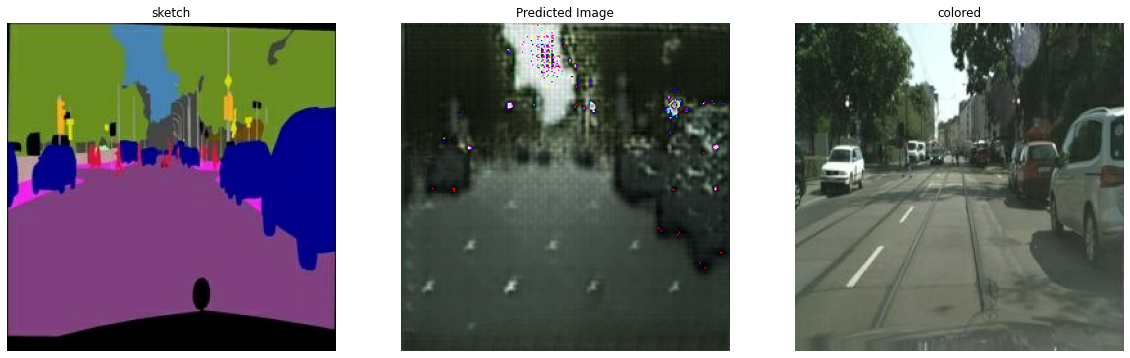

In [28]:
test_ind = 1

f = test_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch)); plt.title('sketch'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(colored));  plt.title('colored'); plt.axis('off')

* 에폭을 10번만 해서 그런지 노이즈가 많이 보입니다.

## cutmix 사용해보기
> cutmix는 2019년 네이버 clova에서 발표한 data agumentation 기법입니다.<br/>
> 원리는 랜덤하게 바운드 박스를 잡고 그 박스 이미지를 잘라 다른 이미지와 합칩니다.

![image](https://user-images.githubusercontent.com/84653776/144835416-46c88d1b-4227-4cfe-a75e-0154fcdec466.png)

* x_1, x_2, y_1, y_2 좌표를 잡고 여러 박스로 나눠서 잘라 믹스 시킵니다.

In [29]:
def random_bbox(image_a, image_b):
    x = np.random.randint(256)
    y = np.random.randint(256)
    
    cut_rat = np.sqrt(1. - np.random.beta(0.5, 0.5))
    cut_w = np.int(256 * cut_rat)
    cut_h = np.int(256 * cut_rat)
    
    x_1 = np.clip(x - cut_w // 2, 0, 256)
    y_1 = np.clip(y - cut_h // 2, 0, 256)
    x_2 = np.clip(x + cut_w // 2, 0, 256)
    y_2 = np.clip(y + cut_h // 2, 0, 256)
    
    return x_1, y_1, x_2, y_2

* 랜덤하게 bbox를 잡아줍니다. 이미지의 크기가 256이기때문에 0부터 256 랜덤하게 4개의 점을 잡아줍니다.

In [30]:
random_bbox(sketch[0], sketch[1])

(0, 0, 181, 149)

* 이런식으로 bbox를 잡게 됩니다.

In [43]:
def mix_image(image_a, image_b, x_1, y_1, x_2, y_2):

    middle_left = image_a[y_1:y_2,0:x_1,:]
    middel_mid = image_b[y_1:y_2,x_1:x_2,:]
    middel_right = image_a[y_1:y_2,x_2:256,:]
    middle = tf.concat([middle_left,middel_mid,middel_right],axis=1)
    top = image_a[0:y_1,:,:]
    bottom = image_a[y_2:256,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

* 그 뒤에 이미지를 섞어주는데 두개의 서로다른 이미지를 입력받으면 랜덤좌표로 이미지를 잘라 다른 이미지랑 섞어주게 됩니다.

In [32]:
def cutmix(sketch, colored):
    image = tf.concat([sketch, colored], axis=-1)
    mixed_sketch = []
    mixed_colored = []
    
    for i in range(2):
        image_a = image[i]
        j = tf.cast(tf.random.uniform([],0, 2),tf.int32)
        image_b = image[j]
        x_1, y_1, x_2, y_2 = random_bbox(image_a, image_b)
        
        mixed_img = mix_image(image_a, image_b, x_1, y_1, x_2, y_2)
        mixed_sketch.append(mixed_img[...,:3])
        mixed_colored.append(mixed_img[...,3:])
        
    return mixed_sketch, mixed_colored

* 위에서 정의한 두 함수를 적용시켜 cutmix를 정의합니다.

In [33]:
f = data_path + os.listdir(data_path)[1]
s = data_path + os.listdir(data_path)[2]
sketch_1, colored_1 = load_img(f)
sketch_2, colored_2 = load_img(s)
sketch = [sketch_1, sketch_2]
colored = [colored_1, colored_2]

* 두개의 이미지를 받아 섞었기때문에 위에서 적용했던 함수랑 다르게 두개의 이미지로 리스트를 만들어 적용시켜 보겠습니다.

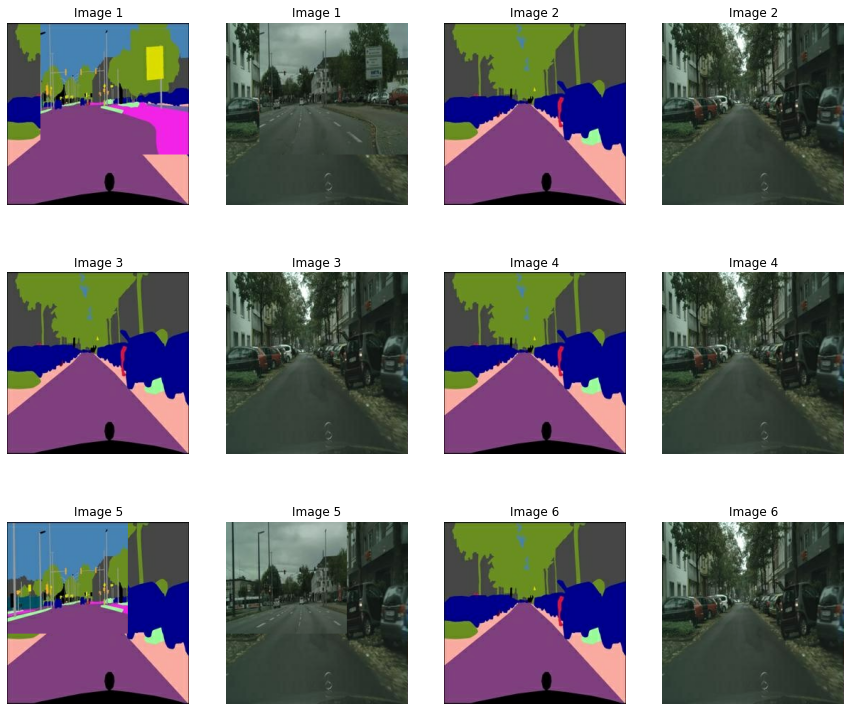

In [34]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    cutmix_sketch, cutmix_colored = cutmix(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(cutmix_sketch[1])); plt.title(f"Image {img_n}"); plt.axis('off')
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(cutmix_colored[1])); plt.title(f"Image {img_n}"); plt.axis('off')
    img_n += 1

* 1번과 5번 이미지를 보면 이미지가 잘린것을 확인할 수 있습니다.

(-0.5, 255.5, 255.5, -0.5)

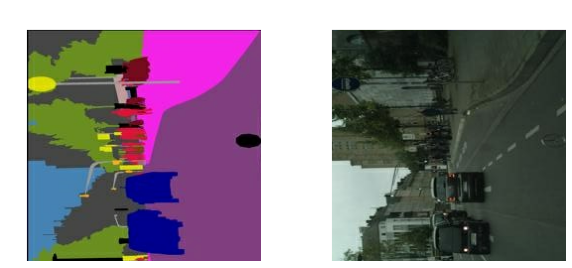

In [35]:
def get_train_cutmix(ds, with_aug=False, with_cutmix=False):
    ds = ds.map(
            load_img 
        )
    if with_aug:
        ds = ds.map(
            apply_augmentation
        )
    if with_cutmix:
        ds = ds.batch(2)
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = get_train_cutmix(train_images, with_aug=True).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8)); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8)); plt.axis('off')

* 위의 함수로 인수를 추가해줍니다.

## cutmix로 학습 및 테스트

In [36]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [37]:
EPOCHS = 10

history_cutmix = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}


generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        history_cutmix['g_loss'].append(g_loss.numpy())
        history_cutmix['l1_loss'].append(l1_loss.numpy())
        history_cutmix['d_loss'].append(d_loss.numpy())
        
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.6488                     
L1_loss:0.2229                     
Discriminator_loss:1.4494

EPOCH[1] - STEP[20]                     
Generator_loss:0.7532                     
L1_loss:0.2253                     
Discriminator_loss:1.4255

EPOCH[1] - STEP[30]                     
Generator_loss:0.7104                     
L1_loss:0.1919                     
Discriminator_loss:1.3255

EPOCH[1] - STEP[40]                     
Generator_loss:0.7882                     
L1_loss:0.2012                     
Discriminator_loss:1.3592

EPOCH[1] - STEP[50]                     
Generator_loss:0.7289                     
L1_loss:0.1736                     
Discriminator_loss:1.1744

EPOCH[1] - STEP[60]                     
Generator_loss:0.8804                     
L1_loss:0.1722                     
Discriminator_loss:1.1654

EPOCH[1] - STEP[70]                     
Generator_loss:0.4328                     
L1_loss:0.1600                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.0994                     
L1_loss:0.1693                     
Discriminator_loss:0.9402

EPOCH[3] - STEP[80]                     
Generator_loss:1.5043                     
L1_loss:0.1695                     
Discriminator_loss:0.9892

EPOCH[3] - STEP[90]                     
Generator_loss:1.0058                     
L1_loss:0.1685                     
Discriminator_loss:0.7106

EPOCH[3] - STEP[100]                     
Generator_loss:1.5167                     
L1_loss:0.2352                     
Discriminator_loss:0.8488

EPOCH[3] - STEP[110]                     
Generator_loss:1.7982                     
L1_loss:0.2327                     
Discriminator_loss:0.2881

EPOCH[3] - STEP[120]                     
Generator_loss:2.5342                     
L1_loss:0.1476                     
Discriminator_loss:0.9338

EPOCH[3] - STEP[130]                     
Generator_loss:1.1157                     
L1_loss:0.1884                

EPOCH[5] - STEP[130]                     
Generator_loss:2.1225                     
L1_loss:0.1698                     
Discriminator_loss:0.9222

EPOCH[5] - STEP[140]                     
Generator_loss:2.8660                     
L1_loss:0.1692                     
Discriminator_loss:1.7047

EPOCH[5] - STEP[150]                     
Generator_loss:1.3698                     
L1_loss:0.1535                     
Discriminator_loss:0.7538

EPOCH[5] - STEP[160]                     
Generator_loss:1.8072                     
L1_loss:0.2073                     
Discriminator_loss:0.4632

EPOCH[5] - STEP[170]                     
Generator_loss:2.0667                     
L1_loss:0.2008                     
Discriminator_loss:0.7522

EPOCH[5] - STEP[180]                     
Generator_loss:1.0291                     
L1_loss:0.1699                     
Discriminator_loss:1.2606

EPOCH[5] - STEP[190]                     
Generator_loss:1.0029                     
L1_loss:0.1885             

EPOCH[7] - STEP[190]                     
Generator_loss:1.6979                     
L1_loss:0.1907                     
Discriminator_loss:0.6021

EPOCH[7] - STEP[200]                     
Generator_loss:1.9028                     
L1_loss:0.1672                     
Discriminator_loss:1.6576

EPOCH[7] - STEP[210]                     
Generator_loss:0.5751                     
L1_loss:0.1894                     
Discriminator_loss:0.9422

EPOCH[7] - STEP[220]                     
Generator_loss:2.2717                     
L1_loss:0.1822                     
Discriminator_loss:1.4920

EPOCH[7] - STEP[230]                     
Generator_loss:0.8126                     
L1_loss:0.1741                     
Discriminator_loss:0.9081

EPOCH[7] - STEP[240]                     
Generator_loss:2.1418                     
L1_loss:0.1874                     
Discriminator_loss:0.2628

EPOCH[7] - STEP[250]                     
Generator_loss:0.9395                     
L1_loss:0.1829             

EPOCH[9] - STEP[250]                     
Generator_loss:2.6113                     
L1_loss:0.1978                     
Discriminator_loss:0.6110

EPOCH[10] - STEP[10]                     
Generator_loss:1.8316                     
L1_loss:0.2092                     
Discriminator_loss:0.2695

EPOCH[10] - STEP[20]                     
Generator_loss:1.2330                     
L1_loss:0.1642                     
Discriminator_loss:1.9937

EPOCH[10] - STEP[30]                     
Generator_loss:1.0314                     
L1_loss:0.1869                     
Discriminator_loss:0.9317

EPOCH[10] - STEP[40]                     
Generator_loss:1.4171                     
L1_loss:0.1771                     
Discriminator_loss:1.0854

EPOCH[10] - STEP[50]                     
Generator_loss:2.8405                     
L1_loss:0.1675                     
Discriminator_loss:1.7630

EPOCH[10] - STEP[60]                     
Generator_loss:2.3192                     
L1_loss:0.1593             

(-0.5, 255.5, 255.5, -0.5)

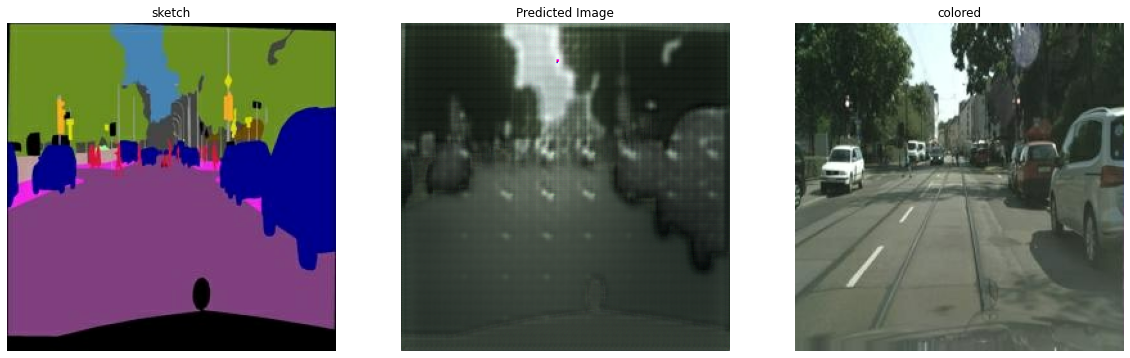

In [38]:
f = test_path + os.listdir(test_path)[1]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch)); plt.title('sketch'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(colored));  plt.title('colored'); plt.axis('off')

* 10번 밖에 학습을 안했지만 노이즈가 상당히 없어진 모습입니다.

## data agumentation 비교

* 텐서플로우 이미지 활용

![image](https://user-images.githubusercontent.com/84653776/144869541-b4adb704-0f7c-498e-ace9-f1b7839a8f6a.png)

* cutmix 활용

![image](https://user-images.githubusercontent.com/84653776/144869640-9d24b60d-9c0d-4e77-ba36-00c258bf1907.png)

* loss값 비교

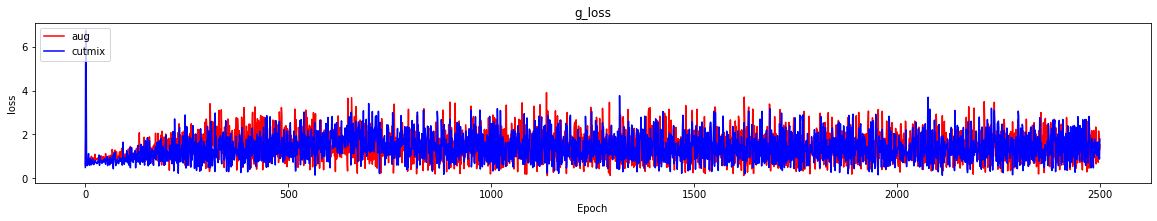

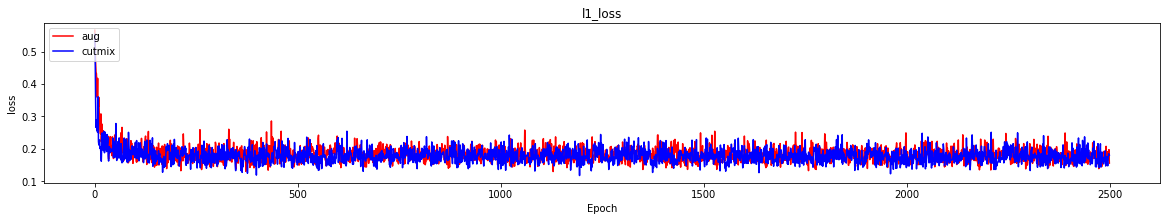

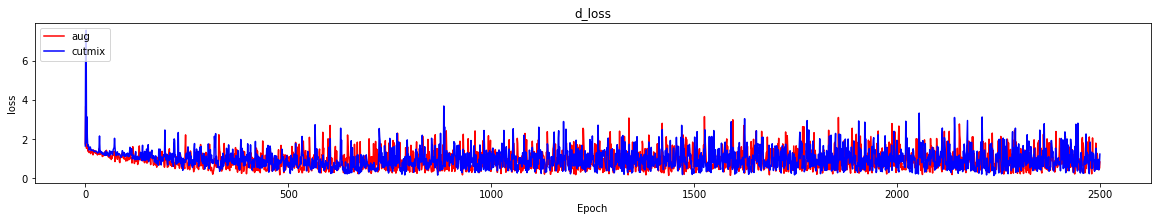

In [41]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(history['g_loss'], 'r')
plt.plot(history_cutmix['g_loss'], 'b')
plt.title('g_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'cutmix'], loc='upper left')

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 2)
plt.plot(history['l1_loss'], 'r')
plt.plot(history_cutmix['l1_loss'], 'b')
plt.title('l1_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'cutmix'], loc='upper left')

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 3)
plt.plot(history['d_loss'], 'r')
plt.plot(history_cutmix['d_loss'], 'b')
plt.title('d_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'cutmix'], loc='upper left')

* 텐서플로우 이미지 라이브러리를 사용한 것과 cutmix의 loss를 비교해보았습니다.<br/>cutmix의 성능이 더 좋은것 같다고 생각했는데 loss는 별 차이가 없습니다.

* 추가로 100에폭 학습을 시켜보겠습니다.

In [44]:
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        history_cutmix['g_loss'].append(g_loss.numpy())
        history_cutmix['l1_loss'].append(l1_loss.numpy())
        history_cutmix['d_loss'].append(d_loss.numpy())
        
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.8457                     
L1_loss:0.1517                     
Discriminator_loss:0.6506

EPOCH[1] - STEP[20]                     
Generator_loss:1.6967                     
L1_loss:0.1807                     
Discriminator_loss:0.4618

EPOCH[1] - STEP[30]                     
Generator_loss:2.2154                     
L1_loss:0.1794                     
Discriminator_loss:0.5732

EPOCH[1] - STEP[40]                     
Generator_loss:2.0654                     
L1_loss:0.1669                     
Discriminator_loss:0.6671

EPOCH[1] - STEP[50]                     
Generator_loss:1.2571                     
L1_loss:0.1894                     
Discriminator_loss:0.5073

EPOCH[1] - STEP[60]                     
Generator_loss:1.5689                     
L1_loss:0.1902                     
Discriminator_loss:0.5094

EPOCH[1] - STEP[70]                     
Generator_loss:1.1279                     
L1_loss:0.1601                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.8291                     
L1_loss:0.1544                     
Discriminator_loss:0.8950

EPOCH[3] - STEP[80]                     
Generator_loss:2.4396                     
L1_loss:0.1989                     
Discriminator_loss:0.1353

EPOCH[3] - STEP[90]                     
Generator_loss:0.5515                     
L1_loss:0.1711                     
Discriminator_loss:1.4207

EPOCH[3] - STEP[100]                     
Generator_loss:1.5886                     
L1_loss:0.1766                     
Discriminator_loss:0.7052

EPOCH[3] - STEP[110]                     
Generator_loss:2.2446                     
L1_loss:0.2050                     
Discriminator_loss:1.6062

EPOCH[3] - STEP[120]                     
Generator_loss:3.4413                     
L1_loss:0.1810                     
Discriminator_loss:1.7336

EPOCH[3] - STEP[130]                     
Generator_loss:2.1804                     
L1_loss:0.1977                

EPOCH[5] - STEP[130]                     
Generator_loss:2.2298                     
L1_loss:0.2275                     
Discriminator_loss:0.2642

EPOCH[5] - STEP[140]                     
Generator_loss:1.2847                     
L1_loss:0.1482                     
Discriminator_loss:0.9973

EPOCH[5] - STEP[150]                     
Generator_loss:0.5149                     
L1_loss:0.1833                     
Discriminator_loss:1.0664

EPOCH[5] - STEP[160]                     
Generator_loss:2.2775                     
L1_loss:0.1638                     
Discriminator_loss:1.0661

EPOCH[5] - STEP[170]                     
Generator_loss:1.9007                     
L1_loss:0.1620                     
Discriminator_loss:0.8600

EPOCH[5] - STEP[180]                     
Generator_loss:1.4495                     
L1_loss:0.1884                     
Discriminator_loss:1.6435

EPOCH[5] - STEP[190]                     
Generator_loss:1.8458                     
L1_loss:0.1703             

EPOCH[7] - STEP[190]                     
Generator_loss:0.5948                     
L1_loss:0.2216                     
Discriminator_loss:1.0262

EPOCH[7] - STEP[200]                     
Generator_loss:0.7872                     
L1_loss:0.1675                     
Discriminator_loss:1.3421

EPOCH[7] - STEP[210]                     
Generator_loss:1.4947                     
L1_loss:0.1904                     
Discriminator_loss:0.3980

EPOCH[7] - STEP[220]                     
Generator_loss:1.2896                     
L1_loss:0.2124                     
Discriminator_loss:1.2588

EPOCH[7] - STEP[230]                     
Generator_loss:2.0466                     
L1_loss:0.1636                     
Discriminator_loss:1.0449

EPOCH[7] - STEP[240]                     
Generator_loss:1.4571                     
L1_loss:0.1939                     
Discriminator_loss:2.5039

EPOCH[7] - STEP[250]                     
Generator_loss:2.5273                     
L1_loss:0.1484             

EPOCH[9] - STEP[250]                     
Generator_loss:0.9063                     
L1_loss:0.2115                     
Discriminator_loss:0.6451

EPOCH[10] - STEP[10]                     
Generator_loss:2.1704                     
L1_loss:0.1549                     
Discriminator_loss:1.2000

EPOCH[10] - STEP[20]                     
Generator_loss:1.7164                     
L1_loss:0.1748                     
Discriminator_loss:0.6440

EPOCH[10] - STEP[30]                     
Generator_loss:2.0359                     
L1_loss:0.1976                     
Discriminator_loss:0.6540

EPOCH[10] - STEP[40]                     
Generator_loss:1.7954                     
L1_loss:0.1577                     
Discriminator_loss:0.8849

EPOCH[10] - STEP[50]                     
Generator_loss:1.8322                     
L1_loss:0.2077                     
Discriminator_loss:0.2676

EPOCH[10] - STEP[60]                     
Generator_loss:0.9602                     
L1_loss:0.1971             

EPOCH[12] - STEP[60]                     
Generator_loss:1.0742                     
L1_loss:0.1781                     
Discriminator_loss:0.5780

EPOCH[12] - STEP[70]                     
Generator_loss:2.1373                     
L1_loss:0.1475                     
Discriminator_loss:1.0381

EPOCH[12] - STEP[80]                     
Generator_loss:1.4810                     
L1_loss:0.1716                     
Discriminator_loss:0.7058

EPOCH[12] - STEP[90]                     
Generator_loss:0.9398                     
L1_loss:0.1681                     
Discriminator_loss:0.7813

EPOCH[12] - STEP[100]                     
Generator_loss:1.5307                     
L1_loss:0.1908                     
Discriminator_loss:0.8403

EPOCH[12] - STEP[110]                     
Generator_loss:0.6966                     
L1_loss:0.1783                     
Discriminator_loss:1.0737

EPOCH[12] - STEP[120]                     
Generator_loss:2.6472                     
L1_loss:0.2005          

EPOCH[14] - STEP[120]                     
Generator_loss:0.9748                     
L1_loss:0.1593                     
Discriminator_loss:1.1098

EPOCH[14] - STEP[130]                     
Generator_loss:1.4905                     
L1_loss:0.1975                     
Discriminator_loss:0.7051

EPOCH[14] - STEP[140]                     
Generator_loss:0.6510                     
L1_loss:0.1961                     
Discriminator_loss:0.8918

EPOCH[14] - STEP[150]                     
Generator_loss:0.9890                     
L1_loss:0.1484                     
Discriminator_loss:1.2093

EPOCH[14] - STEP[160]                     
Generator_loss:1.1597                     
L1_loss:0.1890                     
Discriminator_loss:0.7044

EPOCH[14] - STEP[170]                     
Generator_loss:1.0350                     
L1_loss:0.1635                     
Discriminator_loss:1.0493

EPOCH[14] - STEP[180]                     
Generator_loss:1.6190                     
L1_loss:0.1888      

EPOCH[16] - STEP[180]                     
Generator_loss:0.6698                     
L1_loss:0.1559                     
Discriminator_loss:1.1157

EPOCH[16] - STEP[190]                     
Generator_loss:0.6075                     
L1_loss:0.1677                     
Discriminator_loss:0.9174

EPOCH[16] - STEP[200]                     
Generator_loss:1.6332                     
L1_loss:0.1447                     
Discriminator_loss:1.6872

EPOCH[16] - STEP[210]                     
Generator_loss:1.2695                     
L1_loss:0.1752                     
Discriminator_loss:0.4201

EPOCH[16] - STEP[220]                     
Generator_loss:1.6856                     
L1_loss:0.1922                     
Discriminator_loss:0.3249

EPOCH[16] - STEP[230]                     
Generator_loss:1.0823                     
L1_loss:0.1604                     
Discriminator_loss:0.7846

EPOCH[16] - STEP[240]                     
Generator_loss:0.4055                     
L1_loss:0.1872      

EPOCH[18] - STEP[240]                     
Generator_loss:1.1476                     
L1_loss:0.1947                     
Discriminator_loss:0.4970

EPOCH[18] - STEP[250]                     
Generator_loss:1.3288                     
L1_loss:0.2036                     
Discriminator_loss:0.5371

EPOCH[19] - STEP[10]                     
Generator_loss:1.5175                     
L1_loss:0.1620                     
Discriminator_loss:1.1101

EPOCH[19] - STEP[20]                     
Generator_loss:1.3981                     
L1_loss:0.1597                     
Discriminator_loss:1.0607

EPOCH[19] - STEP[30]                     
Generator_loss:1.2149                     
L1_loss:0.1891                     
Discriminator_loss:0.4823

EPOCH[19] - STEP[40]                     
Generator_loss:2.3138                     
L1_loss:0.2010                     
Discriminator_loss:0.1425

EPOCH[19] - STEP[50]                     
Generator_loss:0.5157                     
L1_loss:0.2046           

EPOCH[21] - STEP[50]                     
Generator_loss:1.7437                     
L1_loss:0.1630                     
Discriminator_loss:0.3253

EPOCH[21] - STEP[60]                     
Generator_loss:1.2859                     
L1_loss:0.1394                     
Discriminator_loss:0.4611

EPOCH[21] - STEP[70]                     
Generator_loss:0.7049                     
L1_loss:0.1862                     
Discriminator_loss:0.8580

EPOCH[21] - STEP[80]                     
Generator_loss:1.3930                     
L1_loss:0.1712                     
Discriminator_loss:1.4941

EPOCH[21] - STEP[90]                     
Generator_loss:2.3134                     
L1_loss:0.1640                     
Discriminator_loss:2.4525

EPOCH[21] - STEP[100]                     
Generator_loss:1.2607                     
L1_loss:0.1796                     
Discriminator_loss:0.7129

EPOCH[21] - STEP[110]                     
Generator_loss:1.5113                     
L1_loss:0.1571           

EPOCH[23] - STEP[110]                     
Generator_loss:1.0562                     
L1_loss:0.1698                     
Discriminator_loss:1.5431

EPOCH[23] - STEP[120]                     
Generator_loss:1.0577                     
L1_loss:0.1561                     
Discriminator_loss:1.5870

EPOCH[23] - STEP[130]                     
Generator_loss:1.9073                     
L1_loss:0.1616                     
Discriminator_loss:0.7791

EPOCH[23] - STEP[140]                     
Generator_loss:0.7477                     
L1_loss:0.1786                     
Discriminator_loss:0.8991

EPOCH[23] - STEP[150]                     
Generator_loss:1.9412                     
L1_loss:0.2058                     
Discriminator_loss:0.4345

EPOCH[23] - STEP[160]                     
Generator_loss:0.7249                     
L1_loss:0.1587                     
Discriminator_loss:1.5283

EPOCH[23] - STEP[170]                     
Generator_loss:1.2762                     
L1_loss:0.1823      

EPOCH[25] - STEP[170]                     
Generator_loss:0.7788                     
L1_loss:0.1919                     
Discriminator_loss:0.7759

EPOCH[25] - STEP[180]                     
Generator_loss:2.0486                     
L1_loss:0.1519                     
Discriminator_loss:1.7805

EPOCH[25] - STEP[190]                     
Generator_loss:1.0216                     
L1_loss:0.1876                     
Discriminator_loss:0.7443

EPOCH[25] - STEP[200]                     
Generator_loss:2.1466                     
L1_loss:0.1455                     
Discriminator_loss:1.5704

EPOCH[25] - STEP[210]                     
Generator_loss:0.4066                     
L1_loss:0.2019                     
Discriminator_loss:1.3195

EPOCH[25] - STEP[220]                     
Generator_loss:0.6618                     
L1_loss:0.1518                     
Discriminator_loss:1.2117

EPOCH[25] - STEP[230]                     
Generator_loss:0.9629                     
L1_loss:0.1400      

EPOCH[27] - STEP[230]                     
Generator_loss:0.9327                     
L1_loss:0.1635                     
Discriminator_loss:1.6609

EPOCH[27] - STEP[240]                     
Generator_loss:2.6439                     
L1_loss:0.1517                     
Discriminator_loss:1.1772

EPOCH[27] - STEP[250]                     
Generator_loss:1.6574                     
L1_loss:0.1520                     
Discriminator_loss:1.0018

EPOCH[28] - STEP[10]                     
Generator_loss:1.0591                     
L1_loss:0.1478                     
Discriminator_loss:1.1385

EPOCH[28] - STEP[20]                     
Generator_loss:1.4981                     
L1_loss:0.1717                     
Discriminator_loss:0.9507

EPOCH[28] - STEP[30]                     
Generator_loss:1.3809                     
L1_loss:0.1895                     
Discriminator_loss:0.3564

EPOCH[28] - STEP[40]                     
Generator_loss:2.5694                     
L1_loss:0.1859          

EPOCH[30] - STEP[40]                     
Generator_loss:0.9404                     
L1_loss:0.1566                     
Discriminator_loss:1.8337

EPOCH[30] - STEP[50]                     
Generator_loss:0.4212                     
L1_loss:0.1768                     
Discriminator_loss:1.2598

EPOCH[30] - STEP[60]                     
Generator_loss:1.0709                     
L1_loss:0.1607                     
Discriminator_loss:0.7057

EPOCH[30] - STEP[70]                     
Generator_loss:0.7599                     
L1_loss:0.1489                     
Discriminator_loss:0.8264

EPOCH[30] - STEP[80]                     
Generator_loss:1.1527                     
L1_loss:0.2045                     
Discriminator_loss:0.4895

EPOCH[30] - STEP[90]                     
Generator_loss:0.5555                     
L1_loss:0.1356                     
Discriminator_loss:2.1042

EPOCH[30] - STEP[100]                     
Generator_loss:1.6132                     
L1_loss:0.2033            

EPOCH[32] - STEP[100]                     
Generator_loss:0.3477                     
L1_loss:0.1767                     
Discriminator_loss:1.3728

EPOCH[32] - STEP[110]                     
Generator_loss:0.8450                     
L1_loss:0.1832                     
Discriminator_loss:0.6930

EPOCH[32] - STEP[120]                     
Generator_loss:0.8076                     
L1_loss:0.1632                     
Discriminator_loss:1.6774

EPOCH[32] - STEP[130]                     
Generator_loss:1.4990                     
L1_loss:0.1744                     
Discriminator_loss:0.5156

EPOCH[32] - STEP[140]                     
Generator_loss:0.7771                     
L1_loss:0.2018                     
Discriminator_loss:0.8312

EPOCH[32] - STEP[150]                     
Generator_loss:0.9744                     
L1_loss:0.1836                     
Discriminator_loss:0.7987

EPOCH[32] - STEP[160]                     
Generator_loss:0.6080                     
L1_loss:0.1538      

EPOCH[34] - STEP[160]                     
Generator_loss:0.9098                     
L1_loss:0.1787                     
Discriminator_loss:0.7273

EPOCH[34] - STEP[170]                     
Generator_loss:1.1490                     
L1_loss:0.1964                     
Discriminator_loss:0.4946

EPOCH[34] - STEP[180]                     
Generator_loss:1.4144                     
L1_loss:0.1722                     
Discriminator_loss:0.4816

EPOCH[34] - STEP[190]                     
Generator_loss:1.7743                     
L1_loss:0.1699                     
Discriminator_loss:2.7835

EPOCH[34] - STEP[200]                     
Generator_loss:1.3551                     
L1_loss:0.1723                     
Discriminator_loss:0.8294

EPOCH[34] - STEP[210]                     
Generator_loss:1.5213                     
L1_loss:0.1505                     
Discriminator_loss:0.4849

EPOCH[34] - STEP[220]                     
Generator_loss:0.8143                     
L1_loss:0.1775      

EPOCH[36] - STEP[220]                     
Generator_loss:2.5314                     
L1_loss:0.1719                     
Discriminator_loss:0.9203

EPOCH[36] - STEP[230]                     
Generator_loss:1.7505                     
L1_loss:0.1696                     
Discriminator_loss:0.5489

EPOCH[36] - STEP[240]                     
Generator_loss:1.1317                     
L1_loss:0.2005                     
Discriminator_loss:0.6788

EPOCH[36] - STEP[250]                     
Generator_loss:1.3866                     
L1_loss:0.1943                     
Discriminator_loss:1.2180

EPOCH[37] - STEP[10]                     
Generator_loss:0.9312                     
L1_loss:0.2021                     
Discriminator_loss:0.9202

EPOCH[37] - STEP[20]                     
Generator_loss:1.6850                     
L1_loss:0.1920                     
Discriminator_loss:0.3933

EPOCH[37] - STEP[30]                     
Generator_loss:1.2414                     
L1_loss:0.2196         

EPOCH[39] - STEP[30]                     
Generator_loss:1.1723                     
L1_loss:0.2112                     
Discriminator_loss:0.5144

EPOCH[39] - STEP[40]                     
Generator_loss:0.7746                     
L1_loss:0.1914                     
Discriminator_loss:0.7763

EPOCH[39] - STEP[50]                     
Generator_loss:0.9881                     
L1_loss:0.1529                     
Discriminator_loss:0.5818

EPOCH[39] - STEP[60]                     
Generator_loss:0.8531                     
L1_loss:0.1853                     
Discriminator_loss:0.7584

EPOCH[39] - STEP[70]                     
Generator_loss:2.1003                     
L1_loss:0.1622                     
Discriminator_loss:0.4615

EPOCH[39] - STEP[80]                     
Generator_loss:1.2753                     
L1_loss:0.1650                     
Discriminator_loss:0.9667

EPOCH[39] - STEP[90]                     
Generator_loss:2.1653                     
L1_loss:0.1573             

EPOCH[41] - STEP[90]                     
Generator_loss:1.1004                     
L1_loss:0.1446                     
Discriminator_loss:1.0295

EPOCH[41] - STEP[100]                     
Generator_loss:1.5600                     
L1_loss:0.1622                     
Discriminator_loss:0.7836

EPOCH[41] - STEP[110]                     
Generator_loss:2.2368                     
L1_loss:0.1656                     
Discriminator_loss:0.5705

EPOCH[41] - STEP[120]                     
Generator_loss:1.1444                     
L1_loss:0.1602                     
Discriminator_loss:1.9698

EPOCH[41] - STEP[130]                     
Generator_loss:1.9254                     
L1_loss:0.1522                     
Discriminator_loss:2.4651

EPOCH[41] - STEP[140]                     
Generator_loss:0.7829                     
L1_loss:0.1649                     
Discriminator_loss:1.0486

EPOCH[41] - STEP[150]                     
Generator_loss:1.5755                     
L1_loss:0.1706       

EPOCH[43] - STEP[150]                     
Generator_loss:1.7554                     
L1_loss:0.1655                     
Discriminator_loss:1.4502

EPOCH[43] - STEP[160]                     
Generator_loss:0.7404                     
L1_loss:0.1680                     
Discriminator_loss:0.8717

EPOCH[43] - STEP[170]                     
Generator_loss:1.9793                     
L1_loss:0.1472                     
Discriminator_loss:0.7798

EPOCH[43] - STEP[180]                     
Generator_loss:0.8289                     
L1_loss:0.1444                     
Discriminator_loss:1.4874

EPOCH[43] - STEP[190]                     
Generator_loss:1.4249                     
L1_loss:0.1672                     
Discriminator_loss:0.3659

EPOCH[43] - STEP[200]                     
Generator_loss:1.0743                     
L1_loss:0.1590                     
Discriminator_loss:0.7491

EPOCH[43] - STEP[210]                     
Generator_loss:1.9936                     
L1_loss:0.1272      

EPOCH[45] - STEP[210]                     
Generator_loss:0.7921                     
L1_loss:0.1713                     
Discriminator_loss:1.7152

EPOCH[45] - STEP[220]                     
Generator_loss:2.1448                     
L1_loss:0.2057                     
Discriminator_loss:0.2181

EPOCH[45] - STEP[230]                     
Generator_loss:1.2173                     
L1_loss:0.1540                     
Discriminator_loss:0.5987

EPOCH[45] - STEP[240]                     
Generator_loss:1.0744                     
L1_loss:0.1866                     
Discriminator_loss:0.8311

EPOCH[45] - STEP[250]                     
Generator_loss:1.5401                     
L1_loss:0.1890                     
Discriminator_loss:0.4538

EPOCH[46] - STEP[10]                     
Generator_loss:1.2559                     
L1_loss:0.2037                     
Discriminator_loss:0.4076

EPOCH[46] - STEP[20]                     
Generator_loss:0.6114                     
L1_loss:0.1810        

EPOCH[48] - STEP[20]                     
Generator_loss:2.0809                     
L1_loss:0.1585                     
Discriminator_loss:0.7490

EPOCH[48] - STEP[30]                     
Generator_loss:0.6385                     
L1_loss:0.1546                     
Discriminator_loss:1.2833

EPOCH[48] - STEP[40]                     
Generator_loss:2.0052                     
L1_loss:0.1729                     
Discriminator_loss:1.0121

EPOCH[48] - STEP[50]                     
Generator_loss:1.9309                     
L1_loss:0.1758                     
Discriminator_loss:0.8181

EPOCH[48] - STEP[60]                     
Generator_loss:1.6740                     
L1_loss:0.1609                     
Discriminator_loss:1.2469

EPOCH[48] - STEP[70]                     
Generator_loss:2.9497                     
L1_loss:0.1577                     
Discriminator_loss:0.6520

EPOCH[48] - STEP[80]                     
Generator_loss:1.2529                     
L1_loss:0.2058             

EPOCH[50] - STEP[80]                     
Generator_loss:1.5439                     
L1_loss:0.1763                     
Discriminator_loss:0.4978

EPOCH[50] - STEP[90]                     
Generator_loss:0.8144                     
L1_loss:0.1863                     
Discriminator_loss:0.7519

EPOCH[50] - STEP[100]                     
Generator_loss:1.6672                     
L1_loss:0.1616                     
Discriminator_loss:0.5106

EPOCH[50] - STEP[110]                     
Generator_loss:1.0729                     
L1_loss:0.1755                     
Discriminator_loss:0.5738

EPOCH[50] - STEP[120]                     
Generator_loss:2.0016                     
L1_loss:0.2142                     
Discriminator_loss:0.2709

EPOCH[50] - STEP[130]                     
Generator_loss:1.7774                     
L1_loss:0.1471                     
Discriminator_loss:1.2761

EPOCH[50] - STEP[140]                     
Generator_loss:1.2864                     
L1_loss:0.1581        

EPOCH[52] - STEP[140]                     
Generator_loss:1.2300                     
L1_loss:0.1741                     
Discriminator_loss:0.4943

EPOCH[52] - STEP[150]                     
Generator_loss:1.2213                     
L1_loss:0.1830                     
Discriminator_loss:0.3915

EPOCH[52] - STEP[160]                     
Generator_loss:1.6037                     
L1_loss:0.1468                     
Discriminator_loss:2.0133

EPOCH[52] - STEP[170]                     
Generator_loss:2.0889                     
L1_loss:0.1295                     
Discriminator_loss:1.7319

EPOCH[52] - STEP[180]                     
Generator_loss:1.5295                     
L1_loss:0.1808                     
Discriminator_loss:0.2953

EPOCH[52] - STEP[190]                     
Generator_loss:1.0203                     
L1_loss:0.1717                     
Discriminator_loss:1.0073

EPOCH[52] - STEP[200]                     
Generator_loss:1.3520                     
L1_loss:0.2126      

EPOCH[54] - STEP[200]                     
Generator_loss:2.3265                     
L1_loss:0.1564                     
Discriminator_loss:0.5925

EPOCH[54] - STEP[210]                     
Generator_loss:2.0756                     
L1_loss:0.1869                     
Discriminator_loss:0.5299

EPOCH[54] - STEP[220]                     
Generator_loss:1.5438                     
L1_loss:0.2206                     
Discriminator_loss:0.4380

EPOCH[54] - STEP[230]                     
Generator_loss:1.5818                     
L1_loss:0.1914                     
Discriminator_loss:0.3740

EPOCH[54] - STEP[240]                     
Generator_loss:1.9753                     
L1_loss:0.1610                     
Discriminator_loss:1.1978

EPOCH[54] - STEP[250]                     
Generator_loss:0.9281                     
L1_loss:0.1894                     
Discriminator_loss:0.6961

EPOCH[55] - STEP[10]                     
Generator_loss:1.3556                     
L1_loss:0.1722       

EPOCH[57] - STEP[10]                     
Generator_loss:0.7506                     
L1_loss:0.1792                     
Discriminator_loss:1.1791

EPOCH[57] - STEP[20]                     
Generator_loss:2.2433                     
L1_loss:0.1938                     
Discriminator_loss:2.3227

EPOCH[57] - STEP[30]                     
Generator_loss:0.5883                     
L1_loss:0.1672                     
Discriminator_loss:1.0973

EPOCH[57] - STEP[40]                     
Generator_loss:2.1867                     
L1_loss:0.1828                     
Discriminator_loss:0.1770

EPOCH[57] - STEP[50]                     
Generator_loss:2.5767                     
L1_loss:0.2012                     
Discriminator_loss:0.1188

EPOCH[57] - STEP[60]                     
Generator_loss:1.7876                     
L1_loss:0.1753                     
Discriminator_loss:0.7018

EPOCH[57] - STEP[70]                     
Generator_loss:0.6136                     
L1_loss:0.1853             

EPOCH[59] - STEP[70]                     
Generator_loss:1.3963                     
L1_loss:0.1497                     
Discriminator_loss:0.8908

EPOCH[59] - STEP[80]                     
Generator_loss:1.9399                     
L1_loss:0.2155                     
Discriminator_loss:0.2762

EPOCH[59] - STEP[90]                     
Generator_loss:1.7016                     
L1_loss:0.1519                     
Discriminator_loss:0.5165

EPOCH[59] - STEP[100]                     
Generator_loss:1.0937                     
L1_loss:0.1603                     
Discriminator_loss:1.2166

EPOCH[59] - STEP[110]                     
Generator_loss:1.1273                     
L1_loss:0.1444                     
Discriminator_loss:1.3534

EPOCH[59] - STEP[120]                     
Generator_loss:0.2333                     
L1_loss:0.1979                     
Discriminator_loss:1.9130

EPOCH[59] - STEP[130]                     
Generator_loss:1.3604                     
L1_loss:0.1512         

EPOCH[61] - STEP[130]                     
Generator_loss:1.9575                     
L1_loss:0.1694                     
Discriminator_loss:1.1437

EPOCH[61] - STEP[140]                     
Generator_loss:2.0744                     
L1_loss:0.1843                     
Discriminator_loss:0.2097

EPOCH[61] - STEP[150]                     
Generator_loss:2.2985                     
L1_loss:0.1835                     
Discriminator_loss:0.2242

EPOCH[61] - STEP[160]                     
Generator_loss:1.4770                     
L1_loss:0.1728                     
Discriminator_loss:0.6283

EPOCH[61] - STEP[170]                     
Generator_loss:1.6247                     
L1_loss:0.1648                     
Discriminator_loss:0.3190

EPOCH[61] - STEP[180]                     
Generator_loss:1.8999                     
L1_loss:0.1476                     
Discriminator_loss:1.7135

EPOCH[61] - STEP[190]                     
Generator_loss:0.2873                     
L1_loss:0.1698      

EPOCH[63] - STEP[190]                     
Generator_loss:1.4039                     
L1_loss:0.1854                     
Discriminator_loss:0.4051

EPOCH[63] - STEP[200]                     
Generator_loss:1.2767                     
L1_loss:0.1487                     
Discriminator_loss:1.0301

EPOCH[63] - STEP[210]                     
Generator_loss:0.9387                     
L1_loss:0.2053                     
Discriminator_loss:0.7607

EPOCH[63] - STEP[220]                     
Generator_loss:0.8599                     
L1_loss:0.1506                     
Discriminator_loss:1.7716

EPOCH[63] - STEP[230]                     
Generator_loss:1.2163                     
L1_loss:0.1653                     
Discriminator_loss:0.4770

EPOCH[63] - STEP[240]                     
Generator_loss:2.1348                     
L1_loss:0.1670                     
Discriminator_loss:1.9645

EPOCH[63] - STEP[250]                     
Generator_loss:0.3979                     
L1_loss:0.1396      

EPOCH[65] - STEP[250]                     
Generator_loss:0.5291                     
L1_loss:0.1780                     
Discriminator_loss:1.0930

EPOCH[66] - STEP[10]                     
Generator_loss:2.6797                     
L1_loss:0.2257                     
Discriminator_loss:0.1188

EPOCH[66] - STEP[20]                     
Generator_loss:1.7509                     
L1_loss:0.1812                     
Discriminator_loss:0.6477

EPOCH[66] - STEP[30]                     
Generator_loss:1.6314                     
L1_loss:0.1557                     
Discriminator_loss:0.8060

EPOCH[66] - STEP[40]                     
Generator_loss:0.8169                     
L1_loss:0.1629                     
Discriminator_loss:1.5031

EPOCH[66] - STEP[50]                     
Generator_loss:1.5236                     
L1_loss:0.1625                     
Discriminator_loss:1.6098

EPOCH[66] - STEP[60]                     
Generator_loss:1.1409                     
L1_loss:0.1626            

EPOCH[68] - STEP[60]                     
Generator_loss:1.2819                     
L1_loss:0.1696                     
Discriminator_loss:1.3623

EPOCH[68] - STEP[70]                     
Generator_loss:2.0619                     
L1_loss:0.1851                     
Discriminator_loss:0.2195

EPOCH[68] - STEP[80]                     
Generator_loss:0.4146                     
L1_loss:0.1602                     
Discriminator_loss:1.8406

EPOCH[68] - STEP[90]                     
Generator_loss:1.7531                     
L1_loss:0.1831                     
Discriminator_loss:0.8839

EPOCH[68] - STEP[100]                     
Generator_loss:1.6650                     
L1_loss:0.2127                     
Discriminator_loss:0.2755

EPOCH[68] - STEP[110]                     
Generator_loss:4.2995                     
L1_loss:0.1426                     
Discriminator_loss:3.1745

EPOCH[68] - STEP[120]                     
Generator_loss:1.4399                     
L1_loss:0.1639          

EPOCH[70] - STEP[120]                     
Generator_loss:1.4179                     
L1_loss:0.1506                     
Discriminator_loss:0.5919

EPOCH[70] - STEP[130]                     
Generator_loss:1.1198                     
L1_loss:0.1670                     
Discriminator_loss:0.5289

EPOCH[70] - STEP[140]                     
Generator_loss:1.9456                     
L1_loss:0.2146                     
Discriminator_loss:0.3092

EPOCH[70] - STEP[150]                     
Generator_loss:2.0063                     
L1_loss:0.1441                     
Discriminator_loss:1.6858

EPOCH[70] - STEP[160]                     
Generator_loss:0.8163                     
L1_loss:0.1583                     
Discriminator_loss:1.1461

EPOCH[70] - STEP[170]                     
Generator_loss:0.7843                     
L1_loss:0.1702                     
Discriminator_loss:0.7590

EPOCH[70] - STEP[180]                     
Generator_loss:1.3611                     
L1_loss:0.1733      

EPOCH[72] - STEP[180]                     
Generator_loss:1.3714                     
L1_loss:0.1482                     
Discriminator_loss:0.4253

EPOCH[72] - STEP[190]                     
Generator_loss:0.8089                     
L1_loss:0.1652                     
Discriminator_loss:1.0020

EPOCH[72] - STEP[200]                     
Generator_loss:2.1316                     
L1_loss:0.1618                     
Discriminator_loss:0.9929

EPOCH[72] - STEP[210]                     
Generator_loss:0.7862                     
L1_loss:0.1744                     
Discriminator_loss:1.0990

EPOCH[72] - STEP[220]                     
Generator_loss:2.1076                     
L1_loss:0.1743                     
Discriminator_loss:1.8061

EPOCH[72] - STEP[230]                     
Generator_loss:0.8923                     
L1_loss:0.1496                     
Discriminator_loss:0.8947

EPOCH[72] - STEP[240]                     
Generator_loss:2.1603                     
L1_loss:0.1449      

EPOCH[74] - STEP[240]                     
Generator_loss:0.4933                     
L1_loss:0.1384                     
Discriminator_loss:1.7489

EPOCH[74] - STEP[250]                     
Generator_loss:0.9827                     
L1_loss:0.1748                     
Discriminator_loss:0.6421

EPOCH[75] - STEP[10]                     
Generator_loss:0.7342                     
L1_loss:0.1590                     
Discriminator_loss:1.1752

EPOCH[75] - STEP[20]                     
Generator_loss:1.5406                     
L1_loss:0.1593                     
Discriminator_loss:1.2631

EPOCH[75] - STEP[30]                     
Generator_loss:2.1489                     
L1_loss:0.1699                     
Discriminator_loss:0.7331

EPOCH[75] - STEP[40]                     
Generator_loss:2.3646                     
L1_loss:0.1810                     
Discriminator_loss:0.3331

EPOCH[75] - STEP[50]                     
Generator_loss:0.7561                     
L1_loss:0.1708           

EPOCH[77] - STEP[50]                     
Generator_loss:1.8179                     
L1_loss:0.1679                     
Discriminator_loss:0.9477

EPOCH[77] - STEP[60]                     
Generator_loss:1.7731                     
L1_loss:0.1709                     
Discriminator_loss:0.2778

EPOCH[77] - STEP[70]                     
Generator_loss:1.5279                     
L1_loss:0.1714                     
Discriminator_loss:0.3941

EPOCH[77] - STEP[80]                     
Generator_loss:0.7094                     
L1_loss:0.2094                     
Discriminator_loss:0.8248

EPOCH[77] - STEP[90]                     
Generator_loss:0.9126                     
L1_loss:0.1648                     
Discriminator_loss:0.6491

EPOCH[77] - STEP[100]                     
Generator_loss:0.8070                     
L1_loss:0.1474                     
Discriminator_loss:1.3072

EPOCH[77] - STEP[110]                     
Generator_loss:1.0173                     
L1_loss:0.1458           

EPOCH[79] - STEP[110]                     
Generator_loss:0.3144                     
L1_loss:0.1923                     
Discriminator_loss:2.1297

EPOCH[79] - STEP[120]                     
Generator_loss:1.5993                     
L1_loss:0.1773                     
Discriminator_loss:0.8449

EPOCH[79] - STEP[130]                     
Generator_loss:1.0758                     
L1_loss:0.1465                     
Discriminator_loss:0.9117

EPOCH[79] - STEP[140]                     
Generator_loss:0.9323                     
L1_loss:0.1489                     
Discriminator_loss:0.9332

EPOCH[79] - STEP[150]                     
Generator_loss:1.7408                     
L1_loss:0.1609                     
Discriminator_loss:1.9942

EPOCH[79] - STEP[160]                     
Generator_loss:1.6861                     
L1_loss:0.1589                     
Discriminator_loss:0.8353

EPOCH[79] - STEP[170]                     
Generator_loss:1.3973                     
L1_loss:0.2046      

EPOCH[81] - STEP[170]                     
Generator_loss:0.8903                     
L1_loss:0.1845                     
Discriminator_loss:0.6797

EPOCH[81] - STEP[180]                     
Generator_loss:1.7490                     
L1_loss:0.1532                     
Discriminator_loss:1.3767

EPOCH[81] - STEP[190]                     
Generator_loss:2.2960                     
L1_loss:0.1972                     
Discriminator_loss:0.7777

EPOCH[81] - STEP[200]                     
Generator_loss:1.7263                     
L1_loss:0.1796                     
Discriminator_loss:0.4269

EPOCH[81] - STEP[210]                     
Generator_loss:1.7669                     
L1_loss:0.1522                     
Discriminator_loss:0.4306

EPOCH[81] - STEP[220]                     
Generator_loss:1.3608                     
L1_loss:0.1774                     
Discriminator_loss:1.4802

EPOCH[81] - STEP[230]                     
Generator_loss:1.2335                     
L1_loss:0.1539      

EPOCH[83] - STEP[230]                     
Generator_loss:1.0011                     
L1_loss:0.1886                     
Discriminator_loss:1.4859

EPOCH[83] - STEP[240]                     
Generator_loss:2.1009                     
L1_loss:0.1875                     
Discriminator_loss:0.6508

EPOCH[83] - STEP[250]                     
Generator_loss:0.8634                     
L1_loss:0.1519                     
Discriminator_loss:0.6683

EPOCH[84] - STEP[10]                     
Generator_loss:0.6526                     
L1_loss:0.1823                     
Discriminator_loss:0.9739

EPOCH[84] - STEP[20]                     
Generator_loss:1.4729                     
L1_loss:0.1958                     
Discriminator_loss:0.5824

EPOCH[84] - STEP[30]                     
Generator_loss:1.2269                     
L1_loss:0.1490                     
Discriminator_loss:1.1410

EPOCH[84] - STEP[40]                     
Generator_loss:1.0391                     
L1_loss:0.1638          

EPOCH[86] - STEP[40]                     
Generator_loss:1.5240                     
L1_loss:0.1439                     
Discriminator_loss:1.3717

EPOCH[86] - STEP[50]                     
Generator_loss:0.8629                     
L1_loss:0.1545                     
Discriminator_loss:1.1950

EPOCH[86] - STEP[60]                     
Generator_loss:0.7692                     
L1_loss:0.1873                     
Discriminator_loss:0.7928

EPOCH[86] - STEP[70]                     
Generator_loss:0.9014                     
L1_loss:0.1665                     
Discriminator_loss:0.7412

EPOCH[86] - STEP[80]                     
Generator_loss:1.1186                     
L1_loss:0.1762                     
Discriminator_loss:0.9901

EPOCH[86] - STEP[90]                     
Generator_loss:1.3584                     
L1_loss:0.1731                     
Discriminator_loss:0.8369

EPOCH[86] - STEP[100]                     
Generator_loss:2.6352                     
L1_loss:0.1451            

EPOCH[88] - STEP[100]                     
Generator_loss:1.1533                     
L1_loss:0.1504                     
Discriminator_loss:1.2038

EPOCH[88] - STEP[110]                     
Generator_loss:1.4173                     
L1_loss:0.1723                     
Discriminator_loss:1.1644

EPOCH[88] - STEP[120]                     
Generator_loss:0.7316                     
L1_loss:0.1598                     
Discriminator_loss:0.7867

EPOCH[88] - STEP[130]                     
Generator_loss:2.3412                     
L1_loss:0.1731                     
Discriminator_loss:0.2555

EPOCH[88] - STEP[140]                     
Generator_loss:1.2546                     
L1_loss:0.1803                     
Discriminator_loss:0.8059

EPOCH[88] - STEP[150]                     
Generator_loss:2.0946                     
L1_loss:0.1772                     
Discriminator_loss:0.2120

EPOCH[88] - STEP[160]                     
Generator_loss:2.0366                     
L1_loss:0.1520      

EPOCH[90] - STEP[160]                     
Generator_loss:0.6310                     
L1_loss:0.1402                     
Discriminator_loss:1.7432

EPOCH[90] - STEP[170]                     
Generator_loss:1.2868                     
L1_loss:0.2047                     
Discriminator_loss:0.4811

EPOCH[90] - STEP[180]                     
Generator_loss:1.0752                     
L1_loss:0.1611                     
Discriminator_loss:0.7366

EPOCH[90] - STEP[190]                     
Generator_loss:0.5386                     
L1_loss:0.1515                     
Discriminator_loss:1.5506

EPOCH[90] - STEP[200]                     
Generator_loss:2.4344                     
L1_loss:0.1687                     
Discriminator_loss:1.4529

EPOCH[90] - STEP[210]                     
Generator_loss:2.0940                     
L1_loss:0.2045                     
Discriminator_loss:1.1071

EPOCH[90] - STEP[220]                     
Generator_loss:1.4918                     
L1_loss:0.1821      

EPOCH[92] - STEP[220]                     
Generator_loss:1.2781                     
L1_loss:0.1729                     
Discriminator_loss:0.5821

EPOCH[92] - STEP[230]                     
Generator_loss:0.6764                     
L1_loss:0.1725                     
Discriminator_loss:1.1113

EPOCH[92] - STEP[240]                     
Generator_loss:1.3865                     
L1_loss:0.1545                     
Discriminator_loss:0.6936

EPOCH[92] - STEP[250]                     
Generator_loss:1.4334                     
L1_loss:0.1666                     
Discriminator_loss:1.2758

EPOCH[93] - STEP[10]                     
Generator_loss:1.3763                     
L1_loss:0.1542                     
Discriminator_loss:0.6558

EPOCH[93] - STEP[20]                     
Generator_loss:1.2400                     
L1_loss:0.1887                     
Discriminator_loss:0.5237

EPOCH[93] - STEP[30]                     
Generator_loss:1.3444                     
L1_loss:0.1987         

EPOCH[95] - STEP[30]                     
Generator_loss:0.4032                     
L1_loss:0.1856                     
Discriminator_loss:1.4571

EPOCH[95] - STEP[40]                     
Generator_loss:1.2952                     
L1_loss:0.1386                     
Discriminator_loss:1.3501

EPOCH[95] - STEP[50]                     
Generator_loss:1.5043                     
L1_loss:0.1461                     
Discriminator_loss:1.0037

EPOCH[95] - STEP[60]                     
Generator_loss:1.7653                     
L1_loss:0.1637                     
Discriminator_loss:0.2559

EPOCH[95] - STEP[70]                     
Generator_loss:0.4147                     
L1_loss:0.1880                     
Discriminator_loss:1.2720

EPOCH[95] - STEP[80]                     
Generator_loss:1.9956                     
L1_loss:0.1752                     
Discriminator_loss:1.0071

EPOCH[95] - STEP[90]                     
Generator_loss:0.9703                     
L1_loss:0.2208             

EPOCH[97] - STEP[90]                     
Generator_loss:0.7463                     
L1_loss:0.1649                     
Discriminator_loss:1.5129

EPOCH[97] - STEP[100]                     
Generator_loss:1.4160                     
L1_loss:0.1448                     
Discriminator_loss:1.7127

EPOCH[97] - STEP[110]                     
Generator_loss:1.3239                     
L1_loss:0.1638                     
Discriminator_loss:0.6396

EPOCH[97] - STEP[120]                     
Generator_loss:0.7399                     
L1_loss:0.1772                     
Discriminator_loss:1.1286

EPOCH[97] - STEP[130]                     
Generator_loss:1.3365                     
L1_loss:0.2208                     
Discriminator_loss:0.3734

EPOCH[97] - STEP[140]                     
Generator_loss:1.7499                     
L1_loss:0.1553                     
Discriminator_loss:1.1695

EPOCH[97] - STEP[150]                     
Generator_loss:1.2632                     
L1_loss:0.1828       

EPOCH[99] - STEP[150]                     
Generator_loss:1.1661                     
L1_loss:0.1580                     
Discriminator_loss:1.5549

EPOCH[99] - STEP[160]                     
Generator_loss:1.1753                     
L1_loss:0.1913                     
Discriminator_loss:1.3475

EPOCH[99] - STEP[170]                     
Generator_loss:0.7765                     
L1_loss:0.1614                     
Discriminator_loss:1.3924

EPOCH[99] - STEP[180]                     
Generator_loss:1.1759                     
L1_loss:0.1834                     
Discriminator_loss:0.5064

EPOCH[99] - STEP[190]                     
Generator_loss:0.6871                     
L1_loss:0.1644                     
Discriminator_loss:1.0244

EPOCH[99] - STEP[200]                     
Generator_loss:0.9863                     
L1_loss:0.2161                     
Discriminator_loss:0.6275

EPOCH[99] - STEP[210]                     
Generator_loss:2.1218                     
L1_loss:0.1956      

(-0.5, 255.5, 255.5, -0.5)

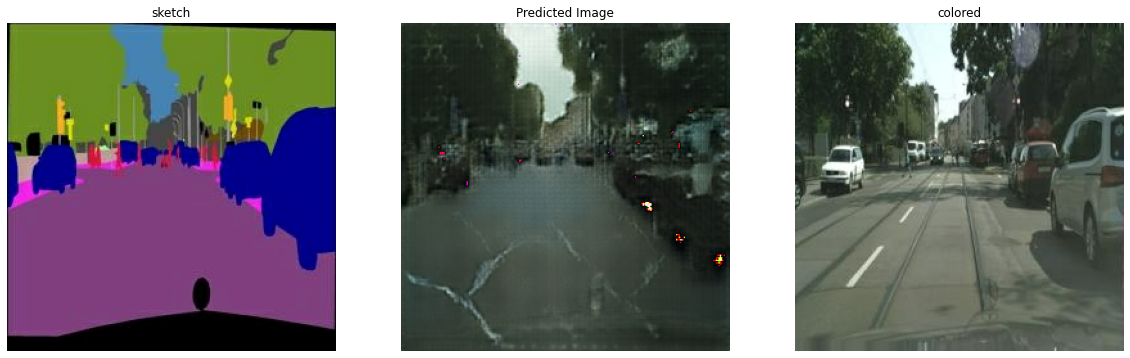

In [45]:
f = test_path + os.listdir(test_path)[1]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch)); plt.title('sketch'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(colored));  plt.title('colored'); plt.axis('off')

* 10 Epoch

![image](https://user-images.githubusercontent.com/84653776/144869640-9d24b60d-9c0d-4e77-ba36-00c258bf1907.png)

* 10 Epoch와 비교해보면 조금 더 사진 같아졌습니다.

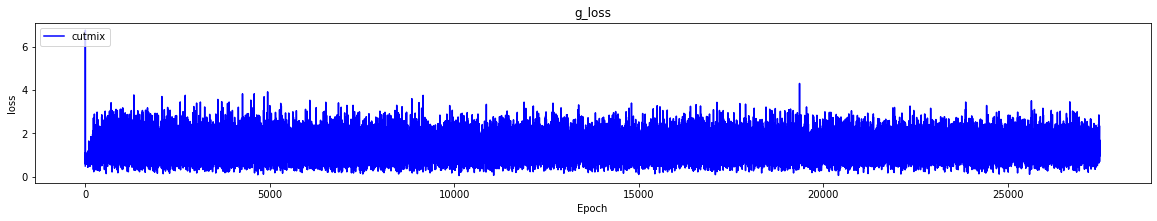

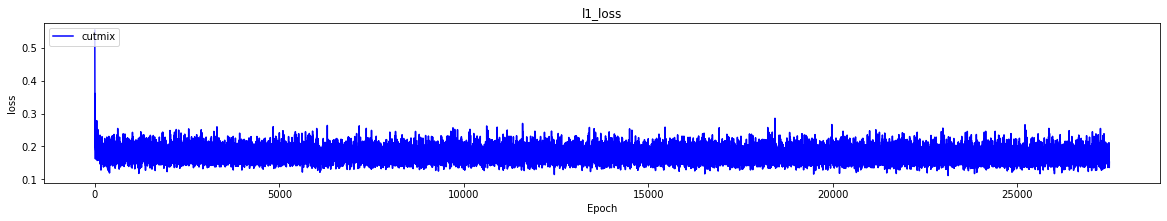

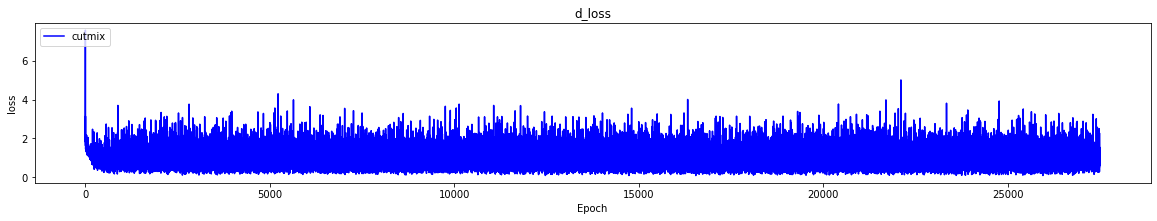

In [47]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(history_cutmix['g_loss'], 'b')
plt.title('g_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['cutmix'], loc='upper left')

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 2)
plt.plot(history_cutmix['l1_loss'], 'b')
plt.title('l1_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['cutmix'], loc='upper left')

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 3)
plt.plot(history_cutmix['d_loss'], 'b')
plt.title('d_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['cutmix'], loc='upper left')

* 로스는 전과 비슷하게 일정 수치를 진동하고 있습니다.

## 회고
> * 텐서플로우 이미지를 활용한 data agumentation과 cutmix를 활용한 방법의 생성 이미지를 보면 성능 차이가 난다고 생각하지만, loss값을 보면 차이가 없습니다. 
> * 추가로 10번 학습한 모델과 110번 학습한 모델도 생성 이미지의 성능 차이는 있지만 loss값의 차이는 없습니다. <br/> loss와 성능의 상관관계가 크지 않다고 생각됩니다.
> * cutmix를 구현하는것 자체는 아주 어렵지는 않지만 이미지를 섞기위해 두 이미지를 인풋값에 적용해야 하기 때문에 data agumentation를 위한 함수를 이해하는게 가장 어려웠던것 같습니다.